<img src="https://d3i71xaburhd42.cloudfront.net/261c3e30bae8b8bdc83541ffa9331b52fcf015e6/3-Figure2-1.png" width=50% >

# <center> Assignment 1: Photometric Stereo & Colour </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59 PM, September 17, 2022 (Amsterdam time) </center>
    
***

## General guidelines
Your code and discussion must be submitted through this jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Lab 1 Assignment. For full credit, make sure your answer follows these guidelines:
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.
Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

## 0 Environment Set Up

You are allowed to use **only** the following library versions:
- python=3.10.4
- matplotlib==3.5.3
- matplotlib-inline==0.1.6
- numpy==1.23.2
- opencv-python==4.6.0.66

Using functions that are not working in these versions could lead to grade deduction.

## 1 Photometric Stereo (50pts)

In this part of the assignment, you are going to implement the photometric stereo algorithm as described in Section 5.4 (Forsyth and Ponce, *Computer Vision: A Modern Approach*). The chapter snippet can be found in the course materials.

Following this instruction, you will have to edit and fill in your code in the functions **estimate_alb_nrm**, **check_integrability**, and **construct_surface**. The main function **photometric_stereo** is provided for reference and should not be taken as is. Throughout the assignment, you will be asked to perform different trials and experiments which will require you to adjust the main code accordingly, this also shows how well you can cope with the materials.

Include images of the results into this notebook. For 3D models, make sure to choose a viewpoint that makes the structure as clear as possible and/or feel free to take them from multiple viewpoints.

### 1.1 Estimating Albedo and Surface Normal (15pts)
Let us start with the grayscale sphere model, which is located in the SphereGray5 folder. The folder contains 5 images of a sphere with grayscale checker texture under similar lighting conditions with the one in the book. Your task is to estimate the surface reflectance (albedo) and surface normal of this model. The light source directions are encoded in the image file names.

1. Complete the code for function **estimate_alb_nrm()** to estimate albedo and surface normal map for the SphereGray5 folder. What do you expect to see in albedo image and how is it different with your result?
2. In principle, what is the minimum number of images you need to estimate albedo and surface normal? Run the algorithm with more images by using SphereGray25 and observe the differences in the results. You could try all images at once or a few at the time, in an incremental fashion. Choose a strategy and justify it by discussing your results.
3. What is the impact of shadows in photometric stereo? Explain the trick that is used in the text to deal with shadows. Remove that trick and check your results. Is the trick necessary in the case of 5 images, how about 25 images?

**Hint**: To get the least-squares solution of a linear system, you can use **numpy.linalg.lstsq** function.

In [2]:
# First some utils we need
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_syn_images(image_dir='./images/photometrics_images/SphereGray25/', channel=0):
    files = os.listdir(image_dir)
    #files = [os.path.join(image_dir, f) for f in files]
    nfiles = len(files)
    
    image_stack = None
    V = 0
    Z = 0.5
    
    for i in range(nfiles):
        # read input image
        im = cv2.imread(os.path.join(image_dir, files[i]))
        im = im[:,:,channel]
        
        # stack at third dimension
        if image_stack is None:
            h, w = im.shape
            print('Image size (H*W): %d*%d' %(h,w) )
            image_stack = np.zeros([h, w, nfiles], dtype=int)
            V = np.zeros([nfiles, 3], dtype=np.float64)
            
        image_stack[:,:,i] = im
        
        # read light direction from image name
        X = np.double(files[i][(files[i].find('_')+1):files[i].rfind('_')])
        Y = np.double(files[i][files[i].rfind('_')+1:files[i].rfind('.png')])
        V[i, :] = [-X, Y, Z]
        
    # normalization
    image_stack = np.double(image_stack)
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    normV = np.tile(np.sqrt(np.sum(V ** 2, axis=1, keepdims=True)), (1, V.shape[1]))
    scriptV = V / normV
    
    return image_stack, scriptV
    
    
def load_face_images(image_dir='./yaleB02/'):
    num_images = 64
    filename = os.path.join(image_dir, 'yaleB02_P00_Ambient.pgm')
    ambient_image = cv2.imread(filename, -1)
    h, w = ambient_image.shape

    # get list of all other image files
    import glob 
    d = glob.glob(os.path.join(image_dir, 'yaleB02_P00A*.pgm'))
    import random
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        ang[0,j], ang[1,j] = np.double(filenames[j][12:16]), np.double(filenames[j][17:20])
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1) - ambient_image


    x = np.cos(np.pi*ang[1,:]/180) * np.cos(np.pi*ang[0,:]/180)
    y = np.cos(np.pi*ang[1,:]/180) * np.sin(np.pi*ang[0,:]/180)
    z = np.sin(np.pi*ang[1,:]/180)
    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    
    return image_stack, scriptV


def load_apple_images(image_dir='./Apples_png/'):
    num_images = 100
    filename = os.path.join(image_dir, 'I_0000.png')
    try_image = cv2.imread(filename, -1)
    h, w = try_image[:,:,0].shape

    # get list of all other image files
    import glob 
    d = glob.glob(os.path.join(image_dir, 'I_00*.png'))
    import random
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]
    filenames_idx = []
    for i in filenames:
        filenames_idx.append(int(i.split('_')[1].split('.')[0]))

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1)[:,:,0]
        
    with open('./images/photometrics_images/Apple/light_directions_refined.txt') as file:
        lines = [line.split() for line in file]
        x, y, z = [], [], []
        for idx in filenames_idx:
            x.append(float(lines[idx][0]))
            y.append(float(lines[idx][1]))
            z.append(float(lines[idx][2]))

    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    
    return image_stack, scriptV
    
    
def show_results(albedo, normals, height_map, SE):
    # Stride in the plot, you may want to adjust it to different images
    stride = 1
    
    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo_max = 1
    albedo = albedo / albedo_max
    print(albedo.shape)
    plt.imshow(albedo, cmap="gray")
    plt.show()
    
    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()
    
    # meshgrid
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
    np.arange(0,np.shape(normals)[1], stride),
    np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    
    '''
    =============
    You could further inspect the shape of the objects and normal directions by using plt.quiver() function.  
    =============
    '''
    
    # plotting the SE
    H = SE[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()
    
    # plotting model geometry
    H = height_map[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()


In [3]:
def estimate_alb_nrm( image_stack, scriptV, shadow_trick=True):
    
    # COMPUTE_SURFACE_GRADIENT compute the gradient of the surface
    # INPUT:
    # image_stack : the images of the desired surface stacked up on the 3rd dimension
    # scriptV : matrix V (in the algorithm) of source and camera information
    # shadow_trick: (true/false) whether or not to use shadow trick in solving linear equations
    # OUTPUT:
    # albedo : the surface albedo
    # normal : the surface normal

    h, w, _ = image_stack.shape
    
    # create arrays for 
    # albedo (1 channel)
    # normal (3 channels)
    albedo = np.zeros([h, w])
    normal = np.zeros([h, w, 3])
    
    """
    ================
    Your code here
    ================
    for each point in the image array
        stack image values into a vector i
        construct the diagonal matrix scriptI
        solve scriptI * scriptV * g = scriptI * i to obtain g for this point
        albedo at this point is |g|
        normal at this point is g / |g|
    """
    for k in range(h):
        for l in range(w):
            i = image_stack[k, l, :]
            scriptI = np.diag(i)
            
            if shadow_trick:
                g = np.linalg.lstsq(scriptI@scriptV, scriptI@i, rcond=None)[0]
            else:
                g = np.linalg.lstsq(scriptV, i, rcond=None)[0]
                
            norm = np.linalg.norm(g)
            albedo[k, l] = norm
            normal[k, l] = 0 if norm == 0 else g/norm
    
    return albedo, normal
    
if __name__ == '__main__':
#     n = 5
#     image_stack = np.zeros([10,10,n])
#     scriptV = np.zeros([n,3])
    image_stack, scriptV = load_syn_images()
    albedo, normal = estimate_alb_nrm( image_stack, scriptV, shadow_trick=True)

FileNotFoundError: [Errno 2] No such file or directory: './images/photometrics_images/SphereGray25/'

### 1.2 Test of Integrability (10pts)

Before we can reconstruct the surface height map, it is required to compute the partial derivatives $\frac{\delta f}{\delta x}$ and $\frac{\delta f}{\delta y}$ (or *p* and *q* in the algorithm). The partial derivatives also give us a chance to double check our computation, namely the test of *integrability*.

1. Compute the partial derivatives (p and q in the algorithm) by filling in your code into **check_integrability()**.

In [ ]:
def check_integrability(normals):
    #  CHECK_INTEGRABILITY check the surface gradient is acceptable
    #   normals: normal image
    #   p : df / dx
    #   q : df / dy
    #   SE : Squared Errors of the 2 second derivatives

    # initalization
    p = np.zeros(normals.shape[:2])
    q = np.zeros(normals.shape[:2])
    SE = np.zeros(normals.shape[:2])
    
    """
    ================
    Your code here
    ================
    Compute p and q, where
    p measures value of df / dx
    q measures value of df / dy
    
    """
    for i in range(normals.shape[0]):
        for j in range(normals.shape[1]):
            norm_vector = normals[i, j]
            p[i, j] = norm_vector[0]/norm_vector[2]
            q[i, j] = norm_vector[1]/norm_vector[2]
            
    # change nan to 0
    p[p!=p] = 0
    q[q!=q] = 0
    
    """
    ================
    Your code here
    ================
    approximate second derivate by neighbor difference
    and compute the Squared Errors SE of the 2 second derivatives SE
    
    """
    # differentiating p with respect to y 
    py = np.zeros(p.shape)
    for col in range(p.shape[1]):
        py[:, col] = np.gradient(p[:, col])
    
    qx = np.zeros(p.shape)
    for row in range(q.shape[0]):
        py[row, :] = np.gradient(q[row, :])
#     py = cv2.Sobel(p, ddepth=-1, dx = 0, dy = 1, ksize = 3)
    # differentiating q with respect to x
#     qx = cv2.Sobel(q, ddepth=-1, dx = 1, dy = 0, ksize = 3)
    SE = (py - qx)**2

    return p, q, SE

if __name__ == '__main__':
#     normals = np.zeros([10,10,3])
    p, q, SE = check_integrability(normal)

2. Implement and compute the second derivatives according to the algorithm and perform the test of integrability by choosing a reasonable threshold. What could be the reasons for the errors? How does the test perform with different number of images used in the reconstruction process in Question 1?

*Write your answer here*

### 1.3 Shape by Integration (10pts)
To reconstruct the surface height map, we need to continuously integrate the partial derivatives over a path. However, as we are working with discrete structures, you will be simply summing their values.

The algorithm in the chapter presents a way to do the integration in column-major order, that is you start at the top-left corner and integrate along the first column, then go towards right along each row. Yet, it is also noticed that it would be better to use many different paths and average so as to spread around the errors in the derivative estimates.

1. Construct the surface height map using column-major order as described in the algorithm, then implement row-major path integration. Your code should now go to **construct_surface()**.

**Note**: By default, Numpy used row-major operations. So if you are unrolling an image to linearize the operation, you will end up with a row-major representation. Numpy can be configured to be column-major. Otherwise, if you are using the double for-loops without an unrolling operation, then this concern doesn’t apply.

**Hint**: You could further inspect the shape of the objects and normal directions by using **matplotlib.pyplot.quiver** function. You will have to choose appropriate sub-sampling ratios for proper illustration. You code goes to the **show_results()** in the first code cell.

In [ ]:
def construct_surface(p, q, path_type='column'):

    '''
    CONSTRUCT_SURFACE construct the surface function represented as height_map
       p : measures value of df / dx
       q : measures value of df / dy
       path_type: type of path to construct height_map, either 'column',
       'row', or 'average'
       height_map: the reconstructed surface
    '''
    
    h, w = p.shape
    height_map = np.zeros([h, w])
    
    if path_type=='column':
        """
        ================
        Your code here
        ================
        % top left corner of height_map is zero
        % for each pixel in the left column of height_map
        %   height_value = previous_height_value + corresponding_q_value
        
        % for each row
        %   for each element of the row except for leftmost
        %       height_value = previous_height_value + corresponding_p_value
        
        """
        height_map = integrate_column_path(height_map, h, w, p, q)
        
    elif path_type=='row':
        """
        ================
        Your code here
        ================
        """
        height_map = integrate_row_path(height_map, h, w, p, q)

                
    elif path_type=='average':
        """
        ================
        Your code here
        ================
        """
        height_map_column = integrate_column_path(np.zeros([h, w]), h, w, p, q)
        height_map_row = integrate_row_path(np.zeros([h, w]), h, w, p, q)
        height_map = (height_map_column+height_map_row)/2
        
    return height_map

def integrate_column_path(height_map, h, w, p, q):
    height_map[0, 0] = 0
    for i in range(1, h):
        height_map[i, 0] = height_map[i-1, 0] + q[i, 0]

    for i in range(h):
        for j in range(1, w):
            height_map[i, j] = height_map[i, j-1] + p[i, j]
    
    return height_map

def integrate_row_path(height_map, h, w, p, q):
    height_map[0, 0] = 0
    for i in range(1, w):
        height_map[0, i] = height_map[0, i-1] + p[0, i]

    for i in range(w):
        for j in range(1, h):
            height_map[i, j] = height_map[i-1, j] + q[i, j]

    return height_map

2. What are the differences in the results of the two paths?


*Write your answer here*

3. Now, take the average of the results. Do you see any improvement compared to when using only one path? Are the construction results different with different number of images being used?

*Write your answer here*

### 1.4 Experiments with different objects (15pts)
In this part, you will try to run the photometric stereo algorithm in various number of scenarios to see how well it can be generalized.

1. Run the algorithm and show the results for the MonkeyGray model. 

In [ ]:
def photometric_stereo(image_dir='./images/photometrics_images/SphereGray5/' ):

    # obtain many images in a fixed view under different illumination
    print('Loading images...\n')
    [image_stack, scriptV] = load_syn_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)

    # compute the surface gradient from the stack of imgs and light source mat
    print('Computing surface albedo and normal map...\n')
    [albedo, normals] = estimate_alb_nrm(image_stack, scriptV)


    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking\n')
    [p, q, SE] = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface( p, q )

    # show results
    show_results(albedo, normals, height_map, SE)

## Face
def photometric_stereo_face(image_dir='./images/photometrics_images/yaleB02/'):
    [image_stack, scriptV] = load_face_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print('Computing surface albedo and normal map...\n')
    albedo, normals = estimate_alb_nrm(image_stack, scriptV)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking')
    p, q, SE = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface(p, q )

    # show results
    show_results(albedo, normals, height_map, SE)
    
## Apple
def photometric_stereo_apple(image_dir='./images/photometrics_images/Apple/'):
    [image_stack, scriptV] = load_apple_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print('Computing surface albedo and normal map...\n')
    albedo, normals = estimate_alb_nrm(image_stack, scriptV)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking')
    p, q, SE = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface(p, q )

    # show results
    show_results(albedo, normals, height_map, SE)

    
if __name__ == '__main__':
    photometric_stereo()
    photometric_stereo('./images/photometrics_images/SphereGray25/')
    photometric_stereo_face()
    photometric_stereo_apple()


2. The albedo results of the monkey may comprise more albedo errors than in case of the sphere. Observe and describe the errors. What could be the reason for those errors? You may want to experiment with different number of images as you did in Question 1 to see the effects. 

*Write your answer here*

3. How do you think that could help solving these errors?

*Write your answer here*

So far, we have assumed that albedos are 1-channel grayscale images and that input images are also 1-channel. To work with 3-channel images, a simple solution is to split the input image into separate channels and treat them individually. Yet, that would generate a small problem while constructing the surface normal map if a pixel value in a channel is zero.

1. Update the implementation to work for 3-channel RGB inputs and test it with 2 models SphereColor and MonkeyColor. 
2. Explain your changes and show your results. 

*Write your answer here*

3. Observe the problem in the constructed surface normal map and height map, explain why a zero pixel could be a problem and propose a way to overcome that.

*Write your answer here*

Now, it's the time to try the algorithm on real-world datasets. For that purpose, we are going to use the [Yale Face Database](http://cvc.cs.yale.edu/cvc/projects/yalefaces/yalefaces.html)

1. Run the algorithm for the Yale Face images (included in the lab material). 
2. Observe and discuss the results for different integration paths. 

**Hint**: For proper computation of albedo and surface normal, you may want to suspend the shadow trick described in the text, and use the original formula:
$$i = Vg(x,y)$$

*Write your answer here*

3. Discuss how the images violate the assumptions of the shape-from-shading methods. Remember to include specific input images to illustrate your points. 


*Write your answer here*

4. How would the results improve when the problematic images are all removed? Try it out and show the results here.

*Write your answer here*

Finally, show your results on real-world 3-channel RGB inputs, contained in the "Apple" folder, taken from [this dataset](http://vision.ucsd.edu/~nalldrin/research/cvpr08/datasets/) from the University of California San Diego.

1. Observe and discuss the results for different integration paths. 

## 2 Colour Spaces (20pts)

In this part of the assignment, you will study the different colour spaces for image representations and experiment how to convert a given RGB image to a specific colour space.

### 2.1 RGB Colour Model (3pts)

Why do we use RGB colour model as a basis of our digital cameras and photography? How does a standard digital camera capture the full RGB colour image?

Red, Green and Blue are the three primary colours that can be blended or added into a very broad range of colours, thus a large space of images can be represented by just multiple sets of 3 8-bit integers. The RGB model is also based on how humans perceive colour. A human eye has 3 different types of cones. These three colour sensors are especially focused on the colours Red, Green and Blue (though Red and Green are by far the most pre-dominant among the cones). A standard digital camera uses either CCD or CMOS to capture the full RGB colour image. They work by converting electromagnetic radiations emitted by lightwaves into electrical charges/voltages. 

### 2.2 Colour Space Conversion (10pts)

Create a function to convert an RGB image into the following colour spaces by using the template code you are provided at the ConvertColourSpace function and other sub-functions. Visualize the new image and its channels separately in the same figure. That is, for example, in the case of HSV colour space, you need to visualize the converted HSV image, and its Hue, Saturation and Value channels separately (4 images, 1 figure). Do not change the already given code.

__Opponent Colour Space__

$\begin{pmatrix}
O_1 \\
O_2 \\
O_3 
\end{pmatrix}$ = $\begin{pmatrix}
\frac{R-G}{\sqrt{2}} \\
\frac{R+G-2B}{\sqrt{6}} \\
\frac{R+G+B}{\sqrt{3}} 
\end{pmatrix}$ 

__Normalized RGB (rgb) Colour Space__

$\begin{pmatrix}
r \\
g \\
b 
\end{pmatrix}$ = $\begin{pmatrix}
\frac{R}{R+G+B} \\
\frac{G}{R+G+B} \\
\frac{B}{R+G+B} 
\end{pmatrix}$ 

__HSV Colour Space__

Convert the RGB image into HSV Colour Space. Use OpenCV’s built-in function *cv2.cvtColor(img, cv2.RGB2HSV)*.

__YCbCr Colour Space__

Convert the RGB image into YCbCr Colour Space. Use OpenCV’s built-in function *cv2.cvtColor(img, cv2.RGB2YCrCb)*. Note, you need to arrange the channels in $Y, C_b$ and $C_r$ order.

__Grayscale__

Convert the RGB image into grayscale by using 3 different methods mentioned in
https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/
In the end, check and report which method OpenCV uses for grayscale conversion, include it as well, and visualize all 4 in the same figure.




In [4]:
def rgb2grays(input_image):
    # converts an RGB into grayscale by using 4 different methods
    R, G, B = getColourChannels(input_image)
    new_image = np.empty((input_image.shape[0], input_image.shape[1], 4))
    
    # ligtness method
    new_image[:, :, 0] = (np.max(input_image, axis=2) + np.min(input_image, axis=2)) / 2

    # average method
    new_image[:, :, 1] = (R + G + B)/3

    # luminosity method
    new_image[:, :, 2] = 0.21*R + 0.72*G + 0.07*B

    # built-in opencv function
    new_image[:, :, 3] = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)

    return new_image


def rgb2opponent(input_image):
    # converts an RGB image into opponent colour space
    R, G, B = getColourChannels(input_image)
    new_image = np.empty(input_image.shape)
    new_image[:, :, 0] = (R-G)/np.sqrt(2)
    new_image[:, :, 1] = (R+G-2*B)/np.sqrt(6)
    new_image[:, :, 2] = (R+G+B)/np.sqrt(3)
    return new_image


def rgb2normedrgb(input_image):
    # converts an RGB image into normalized rgb colour space
    R, G, B = getColourChannels(input_image)
    RGB_total = R + G + B
    new_image = np.empty(input_image.shape)
    new_image[:, :, 0] = R/RGB_total
    new_image[:, :, 1] = G/RGB_total
    new_image[:, :, 2] = B/RGB_total
    
    return new_image


def getColourChannels(input_image):

    R = input_image[:, :, 0]
    G = input_image[:, :, 1]
    B = input_image[:, :, 2]

    return [R, G, B]

In [5]:
def visualize(input_image):
    # Fill in this function. Remember to remove the pass command
    fig, axis = plt.subplots(2, 2)
    fig.tight_layout()
    axis[0, 0].imshow(input_image)
    axis[0, 0].set_title('Full image with new colourspace')
    axis[0, 1].imshow(input_image[:, :, 0])
    axis[0, 1].set_title('First dimension of colourspace')
    axis[1, 0].imshow(input_image[:, :, 1])
    axis[1, 0].set_title('Second dimension of colourspace')
    axis[1, 1].imshow(input_image[:, :, 2])
    axis[1, 1].set_title('Third dimension of colourspace')
    
def visualize_grayscale(input_image):
    fig, axis = plt.subplots(2, 2)
    fig.tight_layout()
    axis[0, 0].imshow(input_image[:, :, 0], cmap='gray')
    axis[0, 0].set_title('Lightness grayscale')
    axis[0, 1].imshow(input_image[:, :, 1], cmap='gray')
    axis[0, 1].set_title('Average grayscale')
    axis[1, 0].imshow(input_image[:, :, 2], cmap='gray')
    axis[1, 0].set_title('Luminosity grayscale')
    axis[1, 1].imshow(input_image[:, :, 3], cmap='gray')
    axis[1, 1].set_title('OpenCV grayscale')

In [6]:
def ConvertColourSpace(input_image, colourspace):
    '''
    Converts an RGB image into a specified color space, visualizes the
    color channels and returns the image in its new color space.

    Colorspace options:
      opponent
      rgb -> for normalized RGB
      hsv
      ycbcr
      gray

    P.S: Do not forget the visualization part!
    '''

    # Convert the image into double precision for conversions
    input_image = input_image.astype(np.float32)

    if colourspace.lower() == 'opponent':
        # fill in the rgb2opponent function
        new_image = rgb2opponent(input_image)

    elif colourspace.lower() == 'rgb':
        # fill in the rgb2normedrgb function
        new_image = rgb2normedrgb(input_image)

    elif colourspace.lower() == 'hsv':
        # use built-in function from opencv
        new_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2HSV)

    elif colourspace.lower() == 'ycbcr':
        # use built-in function from opencv
        new_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2YCrCb)
        cb, cr = new_image[:, :, 2], new_image[:, :, 1]
        new_image[:, :, 1] = cb
        new_image[:, :, 2] = cr

    elif colourspace.lower() == 'gray':
        # fill in the rgb2grays function
        new_image = rgb2grays(input_image)
        visualize_grayscale(new_image)
        return new_image

    else:
        print('Error: Unknown colorspace type [%s]...' % colourspace)
        new_image = input_image

    visualize(new_image)

    return new_image


if __name__ == '__main__':
    ## Replace the image name with a valid image
    img_path = 'images/awb/awb.jpg'
    # Read with opencv
    I = cv2.imread(img_path)
    # Convert from BGR to RGB
    # This is a shorthand.
    I = I[:, :, ::-1]

    out_img = ConvertColourSpace(I, 'ycbcr')


[ WARN:0@2.136] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('images/awb/awb.jpg'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

<b>What grayscale does OpenCV use?</b> OpenCV uses the luminosity grayscale.

### 2.3 Colour Space Properties (5pts)

Explain each of those 5 colour spaces and their properties. What are the benefits of using a different colour space other than RGB? Provide reasons for each of the above cases. You can include your observations from the visualizations.

<b>Grayscale</b>: Grayscale expresses the image in one single matrix of 8bit integers or 0 through 1 floats. Zero indicates totally black, one indicates totally white. It saves space by only using a single dimension of colour. Contrast is also preserved and now expressed in a single matrix, which makes it easier to do feature extraction by i.e. taking derivatives of the image. 

<b>YCbCr</b>: YCbCr consists of three components like RGB. Y is the luma of the image; it determines the black-to-white brightness of an image. This brightness is combined with the two other parts, namely the blue chrominance (Cb) and the red chrominance (Cr). Cb is defined as the blue difference between the luma and the chrominance itself. Cr is the red difference between the luma and the respective chrominance. The human eye is most sensitive to the luma component (or brightness in general); while the chrominance of objects is less important. Therefore RGB is often translated to YCbCr to save storage space, since the luma (Y) will be stored with great precision, but Cb and Cr can be stored with more data efficiency. YCbCr is often used for video transmission to preserve storage.

<b>HSV</b>: HSV has three components: Hue, Saturation and Value. HSV stores colours with a non-linear scale which can be envisioned as a cilinder. The Hue of an image is determined around the circumference of this cilinder, where the scale of 0 to 360 degrees express the difference in colour. Saturation controls the purity/intensity of the colour (relative to the value). If there is no saturation, then the value will determine a colour solely on the grayscale. The value thus decides the brightness of the colour. A zero value will always result in the colour black. HSV has a benefit that is modeled more to the conception of how humans perceive colours of objects. On top of that, just like with YCbCr, the chrominance is split from the luminance which makes it easier to change brightness or intensity of an image without actually messing up the colourscheme.

<b>Normalized RGB</b>: As it states in the name, normalized RGB normalizes a specific component with respect to all three components in the colourscale. This tends to remove dark pitches, shadow and lighting distortions across the image and therefore gives a clearer view of which objects are actually in the image. This could be useful for object detection, where shadows and distortions might trick a detection algorithm into seeing non-existent objects.

<b>Opponent</b>: This colourspace was derived from the opponent process, a theory by Ewald Hering. This is the idea that human perception is based on three channels for seeing colour, a luminance channel and two chromatic channels. The luminance channel is a distinction between black versus white; while the other two channels make distinction between red versus green and blue versus yellow. In our colourspace, $O_1$ represents red versus green, $O_2$ blue versus yellow and $O_3$ is the luminance. It's benefit is thus that a human eye supposedly is better able to make distinctions between objects in opponent colour images, since it adheres to the channel structure in our own cones and rods.  

### 2.4 More on Colour Spaces (2pts)

Find one more colour space from the literature and simply explain its properties and give a use case.

<b>CMYK</b>: CMYK stands for Cyan, Magenta, Yellow and Key. Key can also be seen as Black. The CMYK scheme is mainly used for printers. It is a colourspace that is centered around subtractive colours. RGB is additive, so colours are creating by adding new colour wavelengths. In subtractive colour mixing, various wave lengths are removed and in turn creating new colours. CMYK is naturally used in printing because paper is white. Thus, subtracting colours from white paper gives the best results instead of adding colours onto the white paper.

## 3 Intrinsic Image Decomposition (15pts)
Intrinsic image decomposition is the process of separating an image into its formation components, such as reflectance (albedo) and shading (illumination). <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) Then, under the assumption of body (diffuse) reflection, linear sensor response and narrow band filters, the decomposition of the observed image $I(\vec{x})$ at position $\vec{x}$ can be approximated as the element-wise product of its albedo $R(\vec{x})$ and shading $S(\vec{x})$ intrinsics:

$$I(\vec{x})=R(\vec{x}) \times S(\vec{x})$$

In this part of the assignment, you will experiment with intrinsic image components to perform one of the computational photography applications; material recolouring. For the experiments, we will use images from a synthetic intrinsic image dataset. <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)

<a name="cite_note-1"></a><small>1. [^](#cite_ref-1) H. G. Barrow and J. M. Tenenbaum. Recovering intrinsic scene characteristics from images. Computer Vision Systems, pages 3-26, 1978.</small>

<a name="cite_note-2"></a><small>2. [^](#cite_ref-1) http://www.cic.uab.cat/Datasets/synthetic_intrinsic_image_dataset/



1. What other components can an image be decomposed other than albedo and shading Give an example and explain your reasoning. *(4pts)*

*Write your answer here*

2. If you check the literature, you will see that almost all the intrinsic image decomposition datasets are composed of synthetic images. What might be the reason for that? *(2pts)*

*Write your answer here*

3. Show that you can actually reconstruct the original *turtle.png* image from its intrinsics using *turtle_albedo.png* and *turtle_shading.png*. In the end, your script should output a figure displaying the original image, its intrinsic images and the reconstructed one. Complete the code for function **iid_image_formation()**. *(4pts)*

In [7]:
def iid_image_formation(albedo_img, shading_img):
    """
    ================
    Your code here
    ================
    """
    return

### Recoloring *(5pts)*
Manipulating colours in photographs is an important problem with many applications in computer vision. Since the aim for recolouring algorithms is just to manipulate colours, better results can be obtained for such a task if the albedo image is available as it is independent of confounding illumination effects.

Assume that you are given the *turtle.png* image and you have access to its
intrinsic images *turtle_albedo.png* and *turtle_shading.png*.
1. Find out the true material colour of the turtle in RGB space (which is uniform in this case).
2. Recolour the turtle image with pure green (0, 255, 0). Display the original turtle image and the recoloured version on the same figure. Complete the code for function **recoloring()**.

In [8]:
def recoloring(albedo_img, shading_img):
    """
    ================
    Your code here
    ================
    """
    return

3. Although you have recoloured the object with pure green, the reconstructed images do not seem to display those pure colors and thus the colour distributions over the object do not appear uniform. Explain the reason.

*Write your answer here*

Note that this was a simple case where the image is synthetic, object centered and has only one colour, and you have access to its ground-truth intrinsic images. Real world scenarios require more than just replacing a single colour with another, not to mention the complexity of achieving a decent intrinsic image decomposition.

## 4 Colour Constancy (15pts)

Colour constancy is the ability to perceive colors of objects, invariant to the colour of the light source. The aim for colour constancy algorithms is first to estimate the illuminant of the light source, and then correct the image so that the corrected image appears to be taken under a canonical (white) light source. The task of the automatic white balance (AWB) is to do the same in digital cameras so that the images taken by a digital camera look as natural as possible.

In this part of the assignment, you will implement the most famous colour constancy algorithm; *Grey-World Algorithm*.

### Grey-World Algorithm
The algorithm assumes that, under a white light source, the average colour in a scene should be achromatic (grey, [128, 128, 128]).

1. Complete the function to apply colour correction to an RGB image by using Grey-World algorithm. Display the original image and the colour corrected one on the same figure. Use awb.jpg image to test your algorithm. In the end, you should see that the reddish colour cast on the image is removed and it looks more natural.

  ***Note:*** You do not need to apply any pre or post processing steps. For the calculation or processing, you are not allowed to use any available code or any dedicated library function except *standard Numpy functions*.
   
   ***Hint:*** Check the von Kries model for this step.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


format: JPEG
mode: RGB
size: (256, 320)
RGB mean values =  [121.17 107.4  109.3 ]


Text(0.5, 1.0, 'Gray World Correction')

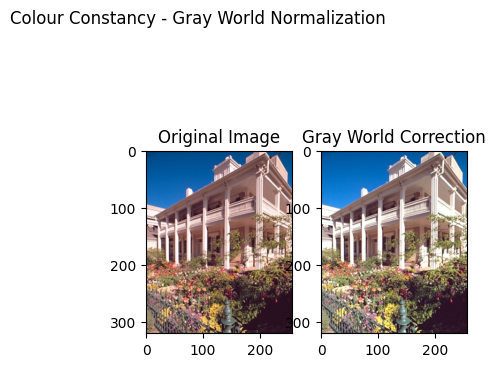

In [11]:
import cv2
from PIL import Image

def grey_world(awb_img):
    """ A function for applying the grey world algorithm to the
    input image file, in order to mimic a colour constancy ability.
    The gray world algorithm [1] assumes that the average colour in a scene 
    is achromatic (gray[128, 128, 128])
    
    Input:
        awb_img = The image file 
        
    Returns:
        cc_img = The color constancy correction
    """
    
    img_array = np.array(awb_img)
    
    # Estimate the mean value per channel
    means = [np.mean(img_array[:,:,i]) for i in range(3)]
    print("RGB mean values = ", np.round(means,2))

    # Colour correction in terms of the gray world normalization
    cc_img = np.dstack((np.array(img_array[:,:,0]*(128/means[0]), dtype=int), np.array(img_array[:,:,1]*(128/means[1]), dtype=int), np.array(img_array[:,:,2]*(128/means[2]), dtype=int))) 
    
    return cc_img

# Source Image
imgAWB = Image.open('images/awb/awb.jpg') 

# prints format, mode, size of i mage 
print('format:', imgAWB.format) 
print('mode:', imgAWB.mode) 
print('size:', imgAWB.size)


# Run Gray World algorithm
imgCC = grey_world(imgAWB)


# Output Images 
fig = plt.figure()
plt.suptitle('Colour Constancy - Gray World Normalization', horizontalalignment='right')

plt.subplot(1, 3, 1)
plt.imshow(imgAWB)    # Red
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(imgCC)    # Green
plt.title('Gray World Correction')


2. Give an example case for Grey-World Algorithm on where it might fail. Remember to include your reasoning.

A nesecarry condition for applying the Gray World assumption to an image is that the image is comprised of sufficient amount of color variation, so that the average value of the R, G and B components do average to the common gray value [128, 128, 128]. Only in this circumstance is it natural to expect that any deviation of the average color away from gray is caused by the effects of the light source. However, not all photograpgs are of scenes comprised of such rich colour spectra. As such, an example of cases where the Gray World algorithm potentially fail is when an image has a large dominant colour patch [2]. For instance, when the motive on a picture is of a singuar color ideal diffuse surface against a minorly displaying more complex background. If this foregorund item for example is a dark shade of red it will cause a low average in the channel which when used to normalize the entire channel can cause a heavy distortion of all other pixels in this spectra. This is because the fundamental assumtion of the average pixel value for the channel should in reality be 128 only weighted by the deviation from the reflected light of the source, which is not the case for this particular scene. 


3. Find out one more colour constancy algorithms from the literature and explain it briefly.

The White-Patch algorithm is a color constancy algorithm often considered to be the alternative to Gray-World for color correction. The fundamental assumption of White-Patch however, is that the maximum response in the RGB-channels is caused by a white patch. The algorithm searches for the lighetst patch  to use as a white reference, in a similar fashion to the mechanisms of the human visual system [3]. In the same fashion as the Gray World algorithm we use a scaling factor to correct the colors in the image. To find this scaling factor the algorithm searches for the RGB values of the white area or pixel, and then it divides all the RGB values by the corresponding RGB values of the white patch. Such an white area can for instance be determined by performing an upper percentile cut in the channels values. In the case that the values exceed the maximum index 255, the values are cropped back to allowed range [4]. 

# References

[1] Buchsbaum, G.: A spatial processor model for object color perception. Journal of the
Franklin Institute 310, 1–26 (1980)

[2] Li, Xiaoqiang & Wu, Jingjing. (2013). Improved Gray World Algorithm Based on Salient Detection. Communications in Computer and Information Science. 363. 315-321. 10.1007/978-3-642-37149-3_38. 

[3] Rizzi, Alessandro & Gatta, Carlo & Marini, Daniele. (2002). Color correction between Gray World and White Patch. Proceedings of SPIE - The International Society for Optical Engineering. 4662. 10.1117/12.469534. 

[4] Cepeda-Negrete, J. y Sanchez-Yanez, RE. (2012). Experiments on the
White Patch Retinex in RGB and CIELAB color spaces. Acta Universitaria,
22 (01886266), 21-26.